In [1]:
import pandas as pd
import numpy as np
from pandas import json_normalize
import japanize_matplotlib
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from adjustText import adjust_text

In [2]:
plt.rcParams['font.size'] = 20
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['font.family'] = 'IPAexGothic'#'Times New Roman'

In [3]:
class CFG:
    input_dir = "../input"
    output_dir = "../output"
    random_seed = 42
    exp_no = "exp000"

In [4]:
train_df = pd.read_csv(f"{CFG.input_dir}/chapter2_demo_data_postprocess.csv")
train_df

,サンプルID,サンプル名,サンプル作成日,担当者,備考,溶媒１,溶媒2,溶媒3,添加剤1,添加剤2,...,乾燥方式,乾燥温度,乾燥時間,擦過回数,擦過圧力,耐擦過性(n10,画像濃度,粘度,表面張力,保存後粘度
0,DP_001,界1_1.5,2024/1/19,高岡,界面活性剤1水準振り,47.4,40,0,2,0,...,0,25,NaN,10,5,0.4,1.07,9,38,NaN
1,DP_002,界1_1.2,2024/1/19,高岡,界面活性剤1水準振り,47.7,40,0,2,0,...,0,25,NaN,10,5,0.4,1.07,9,40,NaN
2,DP_003,界1_1.0,2024/1/19,高岡,界面活性剤1水準振り,47.9,40,0,2,0,...,0,25,NaN,10,5,0.4,1.08,9,41,NaN
3,DP_004,界1_0.5,2024/1/19,高岡,界面活性剤1水準振り,48.4,40,0,2,0,...,0,25,NaN,10,5,0.4,1.09,9,44,NaN
4,DP_005,界1_1.5_樹1_4.0_ref,2024/1/30,福原,ref,47.4,40,0,2,0,...,0,25,NaN,10,5,0.7,1.07,9,38,NaN
5,DP_006,界2_1.5_樹1_4.0,2024/1/30,福原,界面活性剤1種類検討,47.4,40,0,2,0,...,0,25,NaN,10,5,0.7,1.05,9,37,NaN
6,DP_007,界3_1.5_樹1_4.0,2024/1/30,福原,界面活性剤1種類検討,47.4,40,0,2,0,...,0,25,NaN,10,5,0.7,1.02,9,39,NaN
7,DP_008,界1_1.5_樹1_6.0,2024/1/30,福原,定着樹脂１水準振り,45.4,40,0,2,0,...,0,25,NaN,10,5,1.1,1.07,10,36,NaN
8,DP_009,界1_1.5_樹1_8.0,2024/1/30,福原,定着樹脂１水準振り,43.4,40,0,2,0,...,0,25,NaN,10,5,1.6,1.07,11,34,NaN
9,DP_010,界1_1.5_樹1_10.0,2024/1/30,福原,定着樹脂１水準振り,41.4,40,0,2,0,...,0,25,NaN,10,5,2.0,1.07,13,32,NaN


In [5]:
# train_dfの列名をリストで取得
columns = train_df.columns
# train_dfの列名を表示
columns

Index(['サンプルID', 'サンプル名', 'サンプル作成日', '担当者', '備考', '溶媒１', '溶媒2', '溶媒3', '添加剤1',
       '添加剤2', '界面活性剤１', '界面活性剤２', '界面活性剤３', '顔料１', '顔料２', '定着樹脂１', '定着樹脂２',
       '防腐剤', '塗布量', '乾燥方式', '乾燥温度', '乾燥時間', '擦過回数', '擦過圧力', '耐擦過性(n10',
       '画像濃度', '粘度', '表面張力', '保存後粘度'],
      dtype='object')

In [6]:
# 欠損のある列を表示
train_df.isnull().sum()

サンプルID       0
サンプル名        0
サンプル作成日      0
担当者          0
備考           0
溶媒１          0
溶媒2          0
溶媒3          0
添加剤1         0
添加剤2         0
界面活性剤１       0
界面活性剤２       0
界面活性剤３       0
顔料１          0
顔料２          0
定着樹脂１        0
定着樹脂２        0
防腐剤          0
塗布量          0
乾燥方式         0
乾燥温度         0
乾燥時間        12
擦過回数         0
擦過圧力         0
耐擦過性(n10     0
画像濃度         0
粘度           0
表面張力         0
保存後粘度       20
dtype: int64

In [7]:
numeric_parameter_cols = [
    # 'サンプルID', 'サンプル名', 'サンプル作成日', '担当者', '備考', 
    '溶媒１', '溶媒2', '溶媒3', '添加剤1','添加剤2', '界面活性剤１', '界面活性剤２', '界面活性剤３',
    '顔料１', '顔料２', '定着樹脂１', '定着樹脂２','防腐剤', '塗布量', '乾燥方式', '乾燥温度', 
    # '乾燥時間',
    '擦過回数', '擦過圧力',
    # '耐擦過性(n10','画像濃度', '粘度', '表面張力', '保存後粘度'
    ]

In [8]:
# 保存後粘度が欠損している行を削除
train_df = train_df.dropna(subset=["保存後粘度"])
train_df

,サンプルID,サンプル名,サンプル作成日,担当者,備考,溶媒１,溶媒2,溶媒3,添加剤1,添加剤2,...,乾燥方式,乾燥温度,乾燥時間,擦過回数,擦過圧力,耐擦過性(n10,画像濃度,粘度,表面張力,保存後粘度
20,DP_021,溶3_40_添2_2_界1_1.5_樹1_8.0_100℃_0.05,2024/3/15,福原,添加剤、溶媒同時変更,43.4,0,40,0,2,...,1,100,0.03,10,5,5.0,1.09,7,36,10.0
21,DP_022,溶3_40_添2_5_界1_1.5_樹1_8.0_100℃_0.05,2024/3/15,福原,添加剤量振り,40.4,0,40,0,5,...,1,100,0.03,10,5,5.0,1.09,7,33,10.0
22,DP_023,溶3_45_添2_2_界1_1.5_樹1_8.0_100℃_0.05,2024/3/15,福原,溶媒量振り,38.4,0,45,0,2,...,1,100,0.03,10,5,4.4,1.09,7,31,10.0
23,DP_024,溶5_35_添2_2_界1_1.5_樹1_8.0_100℃_0.05,2024/3/15,福原,溶媒量振り,48.4,0,35,0,2,...,1,100,0.03,10,5,5.0,1.09,7,41,10.0
24,DP_025,溶3_40_添2_2_界1_1.5_顔1_5_樹1_8.0_100℃_0.05_ref,2024/3/15,福原,ref,43.4,0,40,0,2,...,1,100,0.03,10,5,4.9,1.09,7,36,10.0
25,DP_026,溶3_40_添2_2_界1_1.5_顔1_7.5_樹1_8.0_100℃_0.05,2024/3/15,福原,顔料振り,40.9,0,40,0,2,...,1,100,0.03,10,5,5.0,1.34,9,34,30.0
26,DP_027,溶3_40_添2_2_界1_1.5_顔1_10_樹1_8.0_100℃_0.05,2024/3/15,福原,顔料振り,38.4,0,40,0,2,...,1,100,0.03,10,5,5.0,1.55,10,32,46.0
27,DP_028,溶3_40_添2_2_界1_1.5_顔2_5_樹1_8.0_100℃_0.05,2024/4/10,高岡,顔料種振り,43.4,0,40,0,2,...,1,100,0.03,10,5,4.9,1.17,8,36,10.0
28,DP_029,溶3_40_添2_2_界1_1.5_顔2_7.5_樹1_8.0_100℃_0.05,2024/4/10,高岡,顔料種振り,40.9,0,40,0,2,...,1,100,0.03,10,5,5.0,1.43,9,34,68.0
29,DP_030,溶3_40_添2_2_界1_1.5_顔2_10_樹1_8.0_100℃_0.05,2024/4/10,高岡,顔料種振り,38.4,0,40,0,2,...,1,100,0.03,10,5,5.0,1.66,10,32,113.0


In [9]:
train_X = train_df[numeric_parameter_cols]
objective_cols = ['保存後粘度']
train_Y = train_df[objective_cols]

0it [00:00, ?it/s]

/Users/takaharawataru/anaconda3/envs/local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/takaharawataru/anaconda3/envs/local/lib/python3.10/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(
/Users/takaharawataru/anaconda3/envs/local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Int64Index([20], dtype='int64')
RMSE_train: 8.467029462466595
MAE_train: 6.686828321746145
R2_train: 0.9381793465338706
Int64Index([21], dtype='int64')
RMSE_train: 8.688904937019363
MAE_train: 6.2017614690931895
R2_train: 0.934896919160996


/Users/takaharawataru/anaconda3/envs/local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/takaharawataru/anaconda3/envs/local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Int64Index([22], dtype='int64')
RMSE_train: 10.715427757668758
MAE_train: 6.819232173866674
R2_train: 0.9009873977514025
Int64Index([23], dtype='int64')
RMSE_train: 8.950056835305993
MAE_train: 7.8129315459957684
R2_train: 0.9309246592665779


/Users/takaharawataru/anaconda3/envs/local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/takaharawataru/anaconda3/envs/local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Int64Index([24], dtype='int64')
RMSE_train: 8.467029462466593
MAE_train: 6.686828321746145
R2_train: 0.9381793465338707
Int64Index([25], dtype='int64')
RMSE_train: 8.49953770221346
MAE_train: 6.35024081105459
R2_train: 0.9406602296550197


/Users/takaharawataru/anaconda3/envs/local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/takaharawataru/anaconda3/envs/local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Int64Index([26], dtype='int64')
RMSE_train: 12.646418713738488
MAE_train: 9.250562162128876
R2_train: 0.865890053325823
Int64Index([27], dtype='int64')
RMSE_train: 6.507056971735469
MAE_train: 5.945326026198618
R2_train: 0.9634875758516128


/Users/takaharawataru/anaconda3/envs/local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Int64Index([28], dtype='int64')
RMSE_train: 8.705901495869945
MAE_train: 6.780628838132238
R2_train: 0.928166123872987


/Users/takaharawataru/anaconda3/envs/local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Int64Index([29], dtype='int64')
RMSE_train: 7.711517804412616
MAE_train: 5.870644746309228
R2_train: 0.8519890592837513


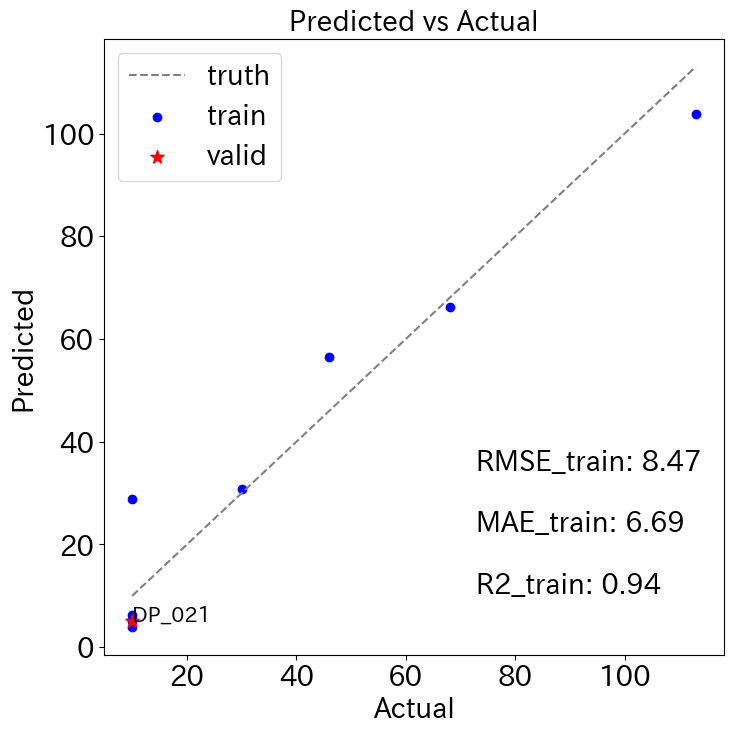

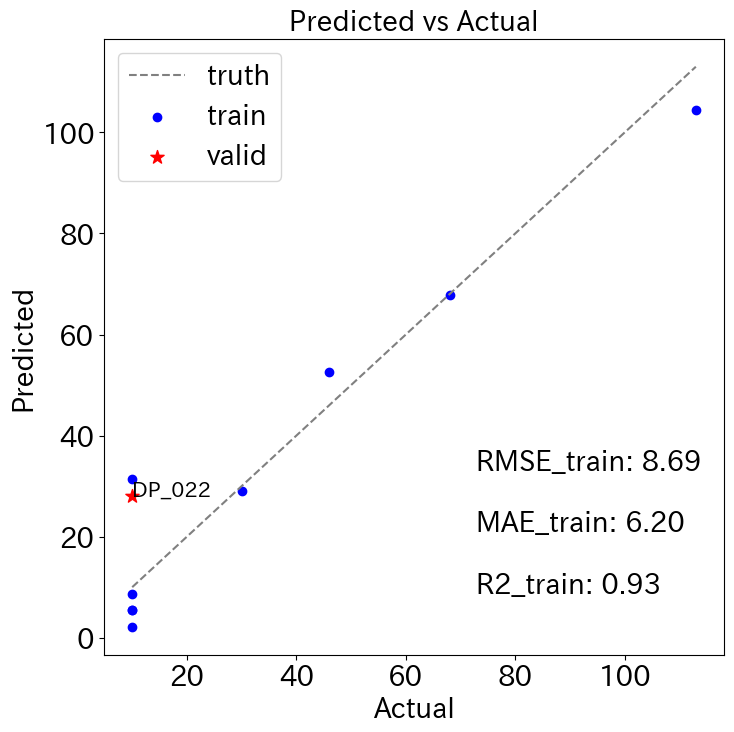

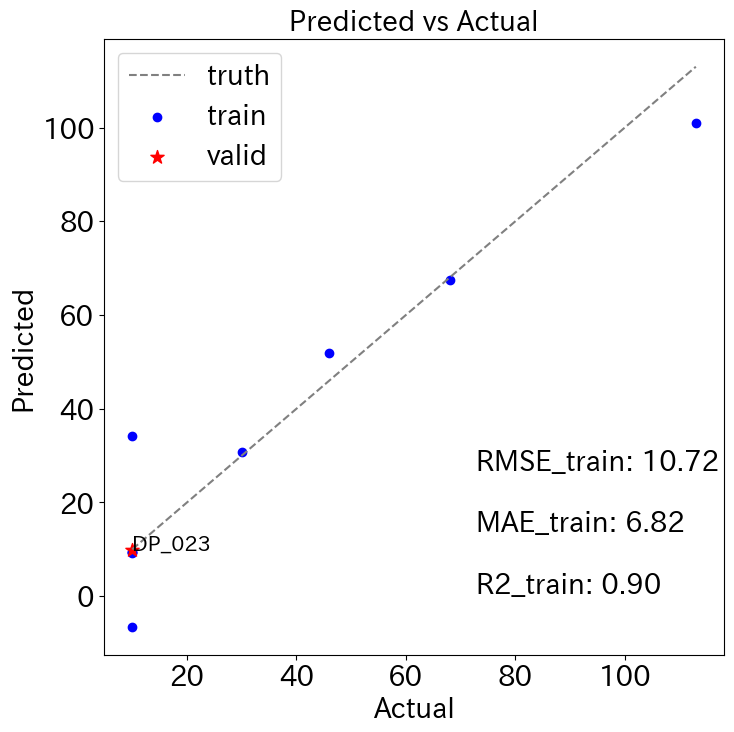

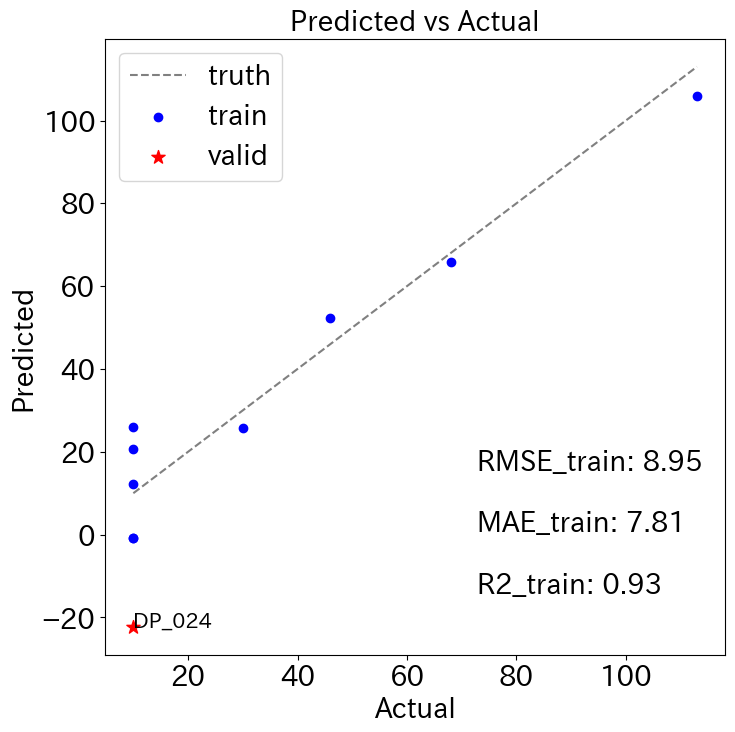

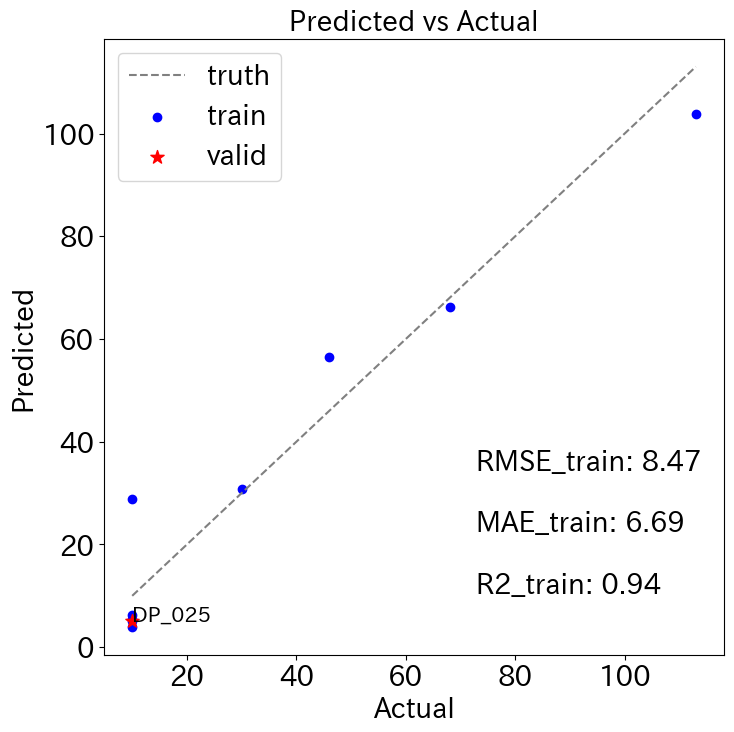

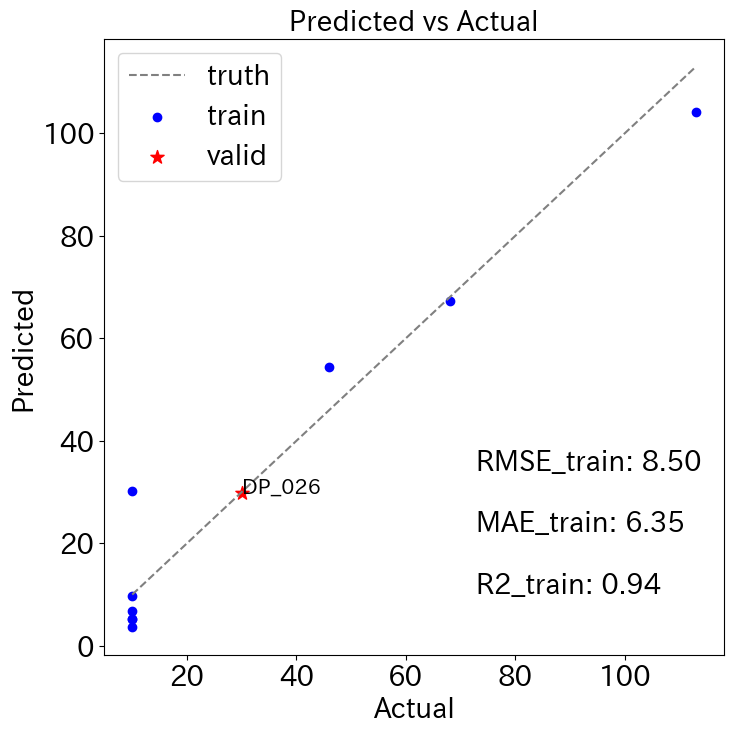

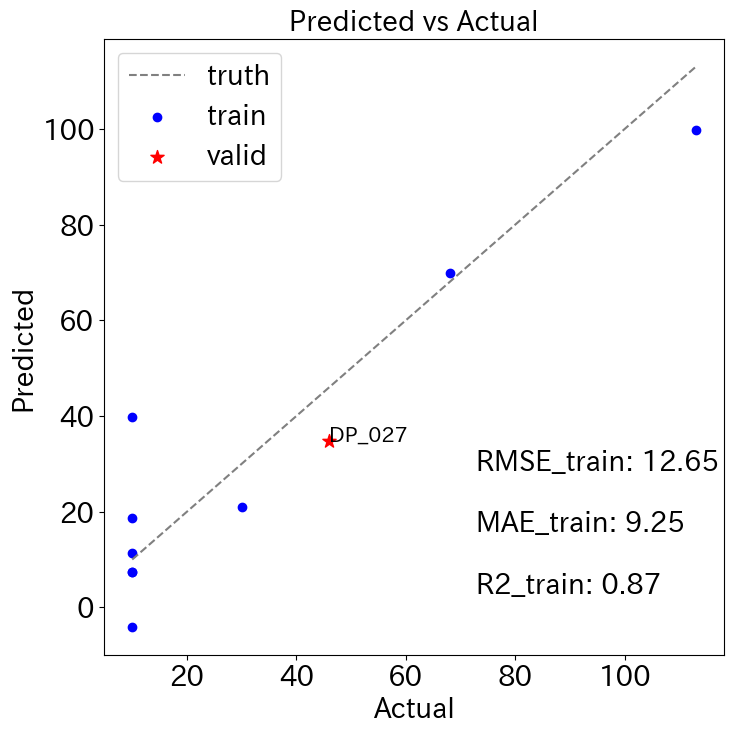

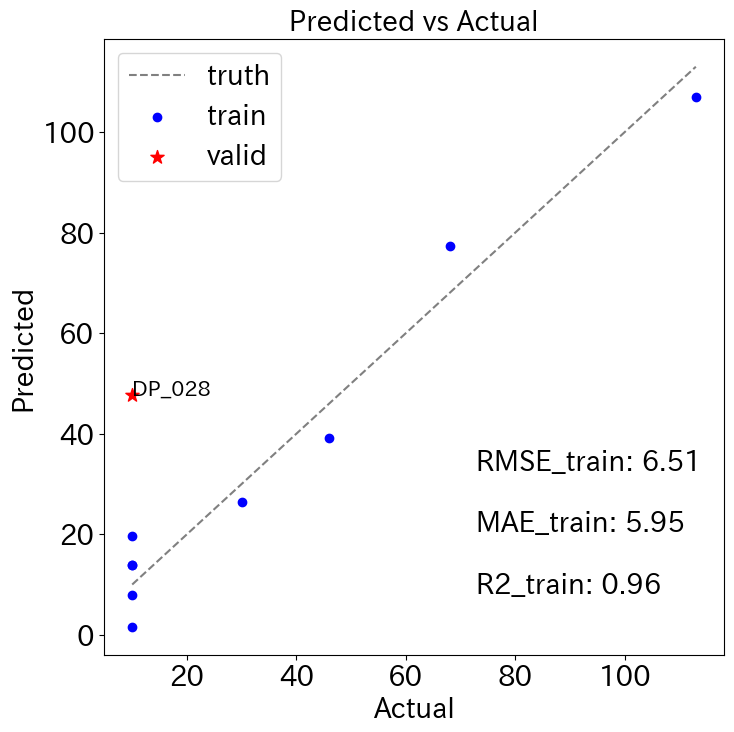

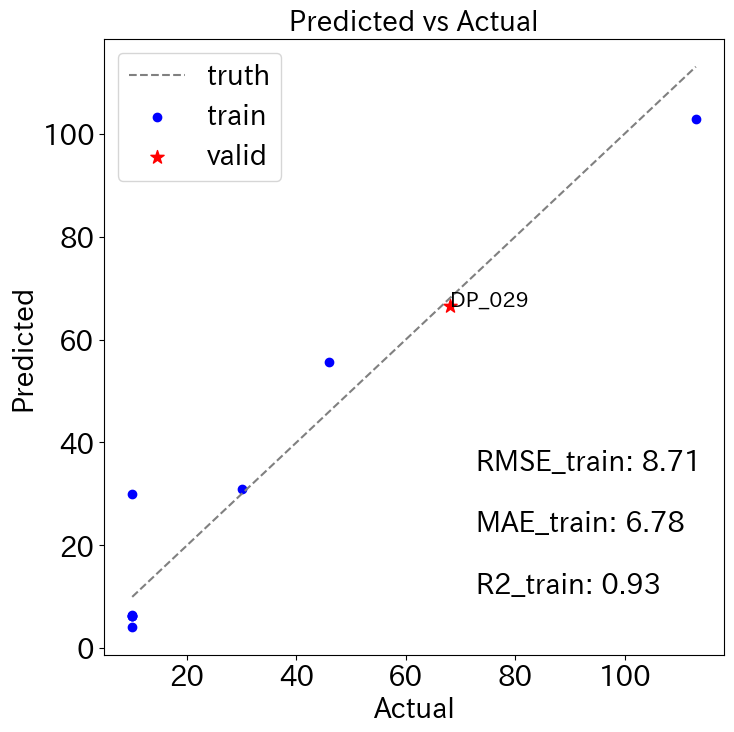

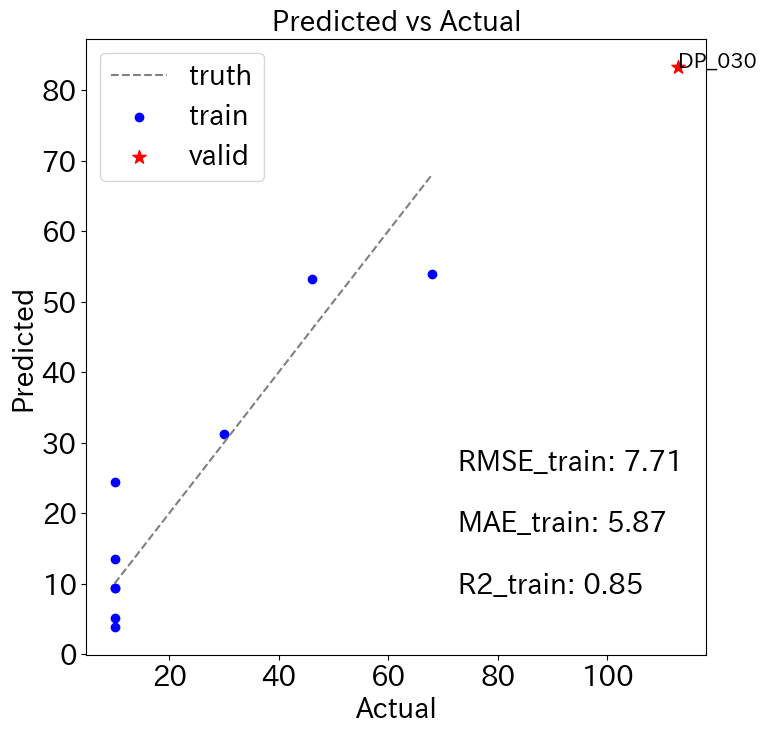

In [10]:
models = []
coef = []
rmses_train = []
maes_train = []
r2_train = []
rmses_valid = []
maes_valid = []
r2_valid = []
oof = np.zeros(len(train_X))

model = PLSRegression(n_components=2)

folds = len(train_X)
kf = KFold(n_splits=folds)

scaler_x = StandardScaler()
scaler_y = StandardScaler()

for train_index, valid_index in tqdm(kf.split(train_X)):
    X_train = scaler_x.fit_transform(train_X.iloc[train_index])
    X_valid = scaler_x.transform(train_X.iloc[valid_index])
    y_train = scaler_y.fit_transform(train_Y.iloc[train_index].values.reshape(-1, 1))
    y_valid = scaler_y.transform(train_Y.iloc[valid_index].values.reshape(-1, 1))

    model.fit(X_train, y_train)
    y_pred_train = scaler_y.inverse_transform(model.predict(X_train).reshape(-1, 1))
    y_pred_valid = scaler_y.inverse_transform(model.predict(X_valid).reshape(-1, 1))

    y_train = scaler_y.inverse_transform(y_train)
    y_valid = scaler_y.inverse_transform(y_valid)

    tmp_rmses_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
    tmp_maes_train = mean_absolute_error(y_train, y_pred_train)
    tmp_r2_train = r2_score(y_train, y_pred_train)

    tmp_rmses_valid = np.sqrt(mean_squared_error(y_valid, y_pred_valid))
    tmp_maes_valid = mean_absolute_error(y_valid, y_pred_valid)
    tmp_r2_valid = r2_score(y_valid, y_pred_valid)

    print(train_Y.iloc[valid_index].index)
    print("RMSE_train:", tmp_rmses_train)
    print("MAE_train:", tmp_maes_train)
    print("R2_train:", tmp_r2_train)
    # print("RMSE_valid:", tmp_rmses_valid)
    # print("MAE_valid:", tmp_maes_valid)
    # print("R2_valid:", tmp_r2_valid)

    models.append(model)
    coef.append(model.coef_)
    rmses_train.append(np.sqrt(mean_squared_error(y_train, y_pred_train)))
    maes_train.append(mean_absolute_error(y_train, y_pred_train))
    r2_train.append(r2_score(y_train, y_pred_train))
    # rmses_valid.append(np.sqrt(mean_squared_error(y_valid, y_pred_valid)))
    # maes_valid.append(mean_absolute_error(y_valid, y_pred_valid))
    # r2_valid.append(r2_score(y_valid, y_pred_valid))

    oof[valid_index] = y_pred_valid

    plt.figure(figsize=(8, 8))
    plt.title('Predicted vs Actual')
    plt.scatter(y_train, y_pred_train, label='train', color='blue')
    plt.scatter(y_valid, y_pred_valid, label='valid', color='red', marker='*', s=100)
    x_truth = np.arange(y_train.min(), y_train.max() +1 )
    y_truth = x_truth
    plt.plot(x_truth, y_truth, '--', color='gray', label='truth')
    # plt.textでRMSE, MAE, R2を右下に表示
    plt.text(0.6, 0.3, f"RMSE_train: {tmp_rmses_train:.2f}", transform=plt.gca().transAxes)
    plt.text(0.6, 0.2, f"MAE_train: {tmp_maes_train:.2f}", transform=plt.gca().transAxes)
    plt.text(0.6, 0.1, f"R2_train: {tmp_r2_train:.2f}", transform=plt.gca().transAxes)
    # plt.txtでvalid_indexに対応するサンプルIDを表示
    for i, txt in enumerate(train_df.iloc[valid_index]['サンプルID']):
        plt.text(y_valid[i], y_pred_valid[i], txt, fontsize=15)

    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.legend()

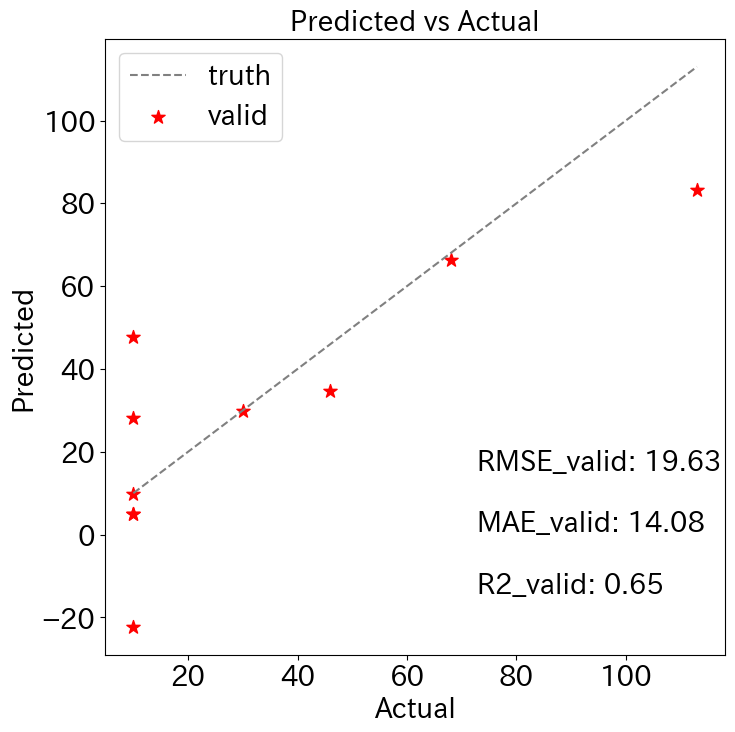

In [11]:
# oofをActualとPredictedに分けてプロット
plt.figure(figsize=(8, 8))
plt.title('Predicted vs Actual')
plt.scatter(train_Y, oof, label='valid', color='red', marker='*', s=100)
x_truth = np.arange(train_Y.values.min(), train_Y.values.max() +1 )
y_truth = x_truth
plt.plot(x_truth, y_truth, '--', color='gray', label='truth')
plt.xlabel('Actual')
plt.ylabel('Predicted')
# plt.textでRMSE, MAE, R2を右下に表示
plt.text(0.6, 0.3, f"RMSE_valid: {np.sqrt(mean_squared_error(train_Y, oof)):.2f}", transform=plt.gca().transAxes)
plt.text(0.6, 0.2, f"MAE_valid: {mean_absolute_error(train_Y, oof):.2f}", transform=plt.gca().transAxes)
plt.text(0.6, 0.1, f"R2_valid: {r2_score(train_Y, oof):.2f}", transform=plt.gca().transAxes)
plt.legend()

               In some cases adjust_text might fail, if possible update
               matplotlib to version >=3.5.0


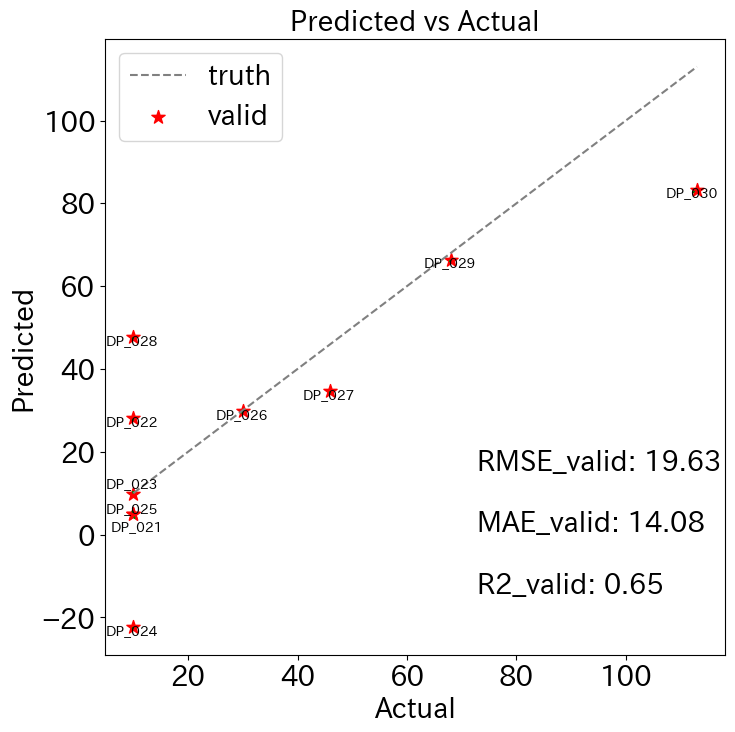

In [13]:
# oofをActualとPredictedに分けてプロット
plt.figure(figsize=(8, 8))
plt.title('Predicted vs Actual')
plt.scatter(train_Y, oof, label='valid', color='red', marker='*', s=100)
x_truth = np.arange(train_Y.values.min(), train_Y.values.max() +1 )
y_truth = x_truth
plt.plot(x_truth, y_truth, '--', color='gray', label='truth')
plt.xlabel('Actual')
plt.ylabel('Predicted')
# plt.textでRMSE, MAE, R2を右下に表示
plt.text(0.6, 0.3, f"RMSE_valid: {np.sqrt(mean_squared_error(train_Y, oof)):.2f}", transform=plt.gca().transAxes)
plt.text(0.6, 0.2, f"MAE_valid: {mean_absolute_error(train_Y, oof):.2f}", transform=plt.gca().transAxes)
plt.text(0.6, 0.1, f"R2_valid: {r2_score(train_Y, oof):.2f}", transform=plt.gca().transAxes)
# plt.txtでvalid_indexに対応するサンプルIDを表示、adjustTextモジュールを使用して、重なりがないように表示
texts = [plt.text(train_Y.values[i], oof[i], train_df.iloc[i]['サンプルID'], fontsize=10) for i in range(len(train_Y))]
adjust_text(texts, arrowprops=dict(arrowstyle='->', color='green'))
plt.legend()

In [14]:
len(coef)

10

In [15]:
# 全てのモデルの係数の平均を算出
coef = np.array(coef)
coef = np.mean(coef, axis=0)
coef

array([[-0.68485053],
       [ 0.        ],
       [-0.50793584],
       [ 0.        ],
       [-0.21732967],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.18259238],
       [ 0.78545279],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ]])

In [16]:
# coefをDataFrameに変換
coef_df = pd.DataFrame(coef, index=numeric_parameter_cols, columns=['coef'])
coef_df

,coef
溶媒１,-0.684851
溶媒2,0.000000
溶媒3,-0.507936
添加剤1,0.000000
添加剤2,-0.217330
界面活性剤１,0.000000
界面活性剤２,0.000000
界面活性剤３,0.000000
顔料１,0.182592
顔料２,0.785453


In [17]:
# coef_dfをcoefの絶対値の降順にソート
coef_df = coef_df.reindex(coef_df['coef'].abs().sort_values(ascending=False).index)
coef_df

,coef
顔料２,0.785453
溶媒１,-0.684851
溶媒3,-0.507936
添加剤2,-0.217330
顔料１,0.182592
添加剤1,0.000000
界面活性剤１,0.000000
界面活性剤２,0.000000
界面活性剤３,0.000000
溶媒2,0.000000


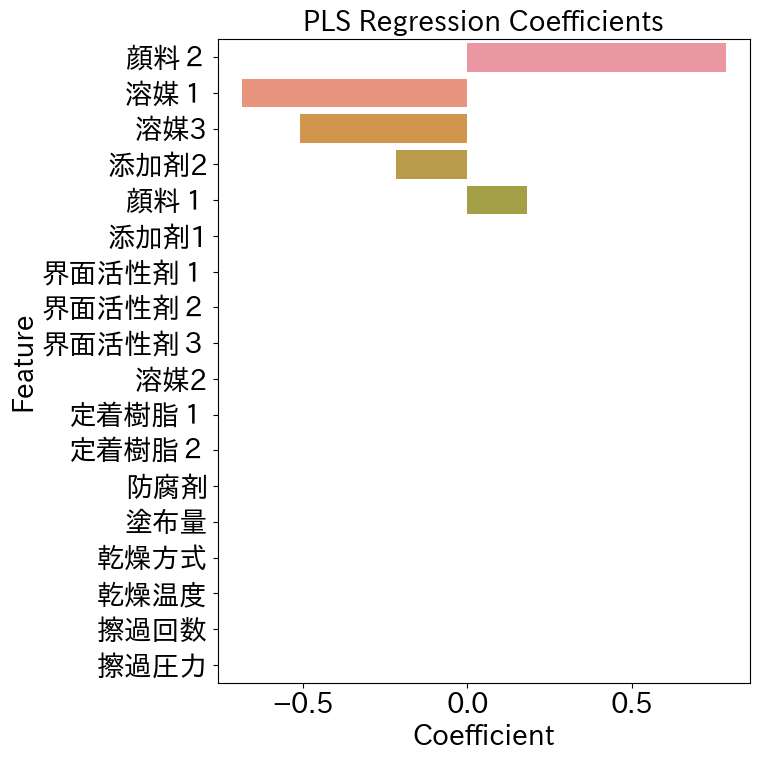

In [18]:
# coef_dfをsns.barplotで可視化
plt.figure(figsize=(8, 8))
sns.barplot(data=coef_df, x='coef', y=coef_df.index)
plt.title('PLS Regression Coefficients')
plt.xlabel('Coefficient')
plt.ylabel('Feature')
plt.tight_layout()

In [19]:
test_df = pd.read_csv(f"{CFG.input_dir}/chapter2_demo_data_postprocess_test.csv")
test_df

,サンプルID,サンプル名,サンプル作成日,担当者,備考,溶媒１,溶媒2,溶媒3,添加剤1,添加剤2,...,顔料２,定着樹脂１,定着樹脂２,防腐剤,塗布量,乾燥方式,乾燥温度,乾燥時間,擦過回数,擦過圧力
0,DP_0XX,test,NaN,NaN,NaN,42.9,0,40,0,2,...,6,6,0,0.1,2,1,100,0.03,10,5


In [20]:
#全てのmodelで予測してその平均をとる
test_X = test_df[numeric_parameter_cols]
preds = []
for model in models:
    pred = scaler_y.inverse_transform(model.predict(scaler_x.transform(test_X)).reshape(-1, 1))
    preds.append(pred)
preds = np.array(preds)
preds = preds.mean(axis=0)
preds

array([[40.45561501]])